# Setup

In [1]:
import tensorflow as tf
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
!pip install kaggle

In [ ]:
pip install split-folders

# Get Data

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d sumn2u/garbage-classification-v2

Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
License(s): MIT
 99% 741M/752M [00:10<00:00, 88.6MB/s]
100% 752M/752M [00:10<00:00, 75.5MB/s]


In [2]:
local_zip_path = "/content/garbage-classification-v2.zip"

with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/trash-dataset")

data_dir = "/content/trash-dataset"

In [3]:
data_dir = "/content/trash-dataset"

In [4]:
classes = os.listdir(data_dir)

In [5]:
print("Folders :")
for class_name in classes:
    print(class_name)

Folders :
trash
glass
cardboard
shoes
battery
biological
plastic
clothes
metal
paper


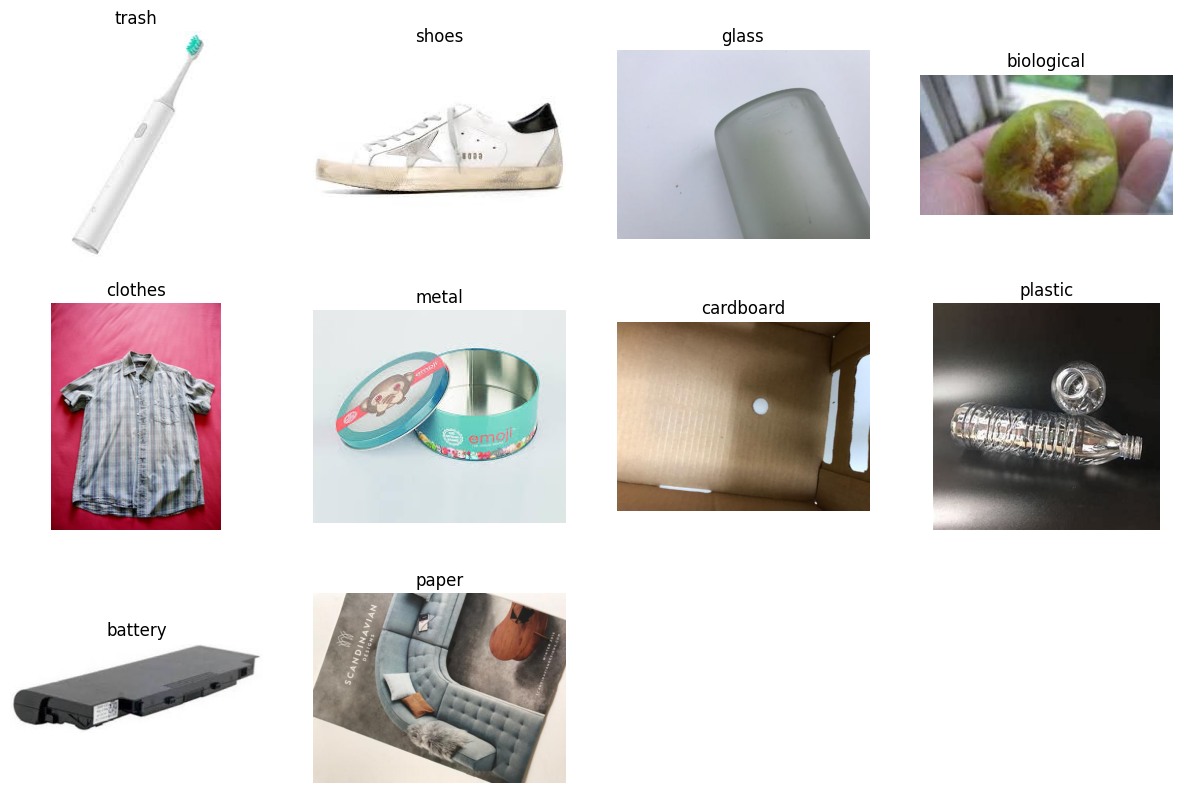

In [ ]:
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    file_names = os.listdir(class_dir)
    file_name = os.path.join(class_dir, file_names[2])

    img = plt.imread(file_name)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.show()

# Split Data

In [6]:
splitfolders.ratio('/content/trash-dataset', output='/content/trash-dataset-split', seed=1337, ratio=(.7, .3))

print("\nData has been successfully split into training and validation sets.")

Copying files: 23642 files [00:13, 1741.14 files/s]


Data has been successfully split into training and validation sets.


# Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [8]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    '/content/trash-dataset-split/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

Found 18910 images belonging to 10 classes.


In [10]:
validation_generator = validation_datagen.flow_from_directory(
    '/content/trash-dataset-split/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

Found 7099 images belonging to 10 classes.


In [11]:
class_names = os.listdir(data_dir)
n_classes = len(class_names)
print(n_classes, class_names)

10 ['trash', 'glass', 'cardboard', 'shoes', 'battery', 'biological', 'plastic', 'clothes', 'metal', 'paper']


In [ ]:
def plot_augmentation(generator, class_names):
    fig, ax = plt.subplots(2, 5, figsize=(20, 10))
    class_indices = {v: k for k, v in generator.class_indices.items()}
    images_shown = {class_name: False for class_name in class_names}
    while not all(images_shown.values()):
        img, label = generator.next()
        class_name = class_indices[label[0].argmax()]
        if not images_shown[class_name]:
            class_idx = class_names.index(class_name)
            row = class_idx // 5
            col = class_idx % 5
            ax[row, col].imshow(img[0])
            ax[row, col].axis('off')
            ax[row, col].set_title(class_name)
            images_shown[class_name] = True
    plt.show()

class_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
plot_augmentation(train_generator, class_names)

# Model

In [12]:
num_classes = 10

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

# Training Model

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=1, restore_best_weights=True, baseline=0.92)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001, verbose=1)

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
590/590 [==============================] - 162s 266ms/step - loss: 1.5621 - accuracy: 0.4603 - val_loss: 1.1699 - val_accuracy: 0.6020 - lr: 0.0010
Epoch 2/50
590/590 [==============================] - 156s 264ms/step - loss: 1.1413 - accuracy: 0.6107 - val_loss: 1.1281 - val_accuracy: 0.6196 - lr: 0.0010
Epoch 3/50
590/590 [==============================] - 157s 267ms/step - loss: 0.9761 - accuracy: 0.6754 - val_loss: 0.8546 - val_accuracy: 0.7168 - lr: 0.0010
Epoch 4/50
590/590 [==============================] - 156s 264ms/step - loss: 0.8536 - accuracy: 0.7166 - val_loss: 0.6884 - val_accuracy: 0.7735 - lr: 0.0010
Epoch 5/50
590/590 [==============================] - 151s 257ms/step - loss: 0.7552 - accuracy: 0.7519 - val_loss: 0.6112 - val_accuracy: 0.8043 - lr: 0.0010
Epoch 6/50
590/590 [==============================] - 150s 254ms/step - loss: 0.6888 - accuracy: 0.7771 - val_loss: 0.5703 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 7/50
590/590 [==========================

# History

In [16]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

222/222 [==============================] - 18s 80ms/step - loss: 0.4401 - accuracy: 0.8835
Validation Loss: 0.4400511085987091
Validation Accuracy: 0.8835047483444214


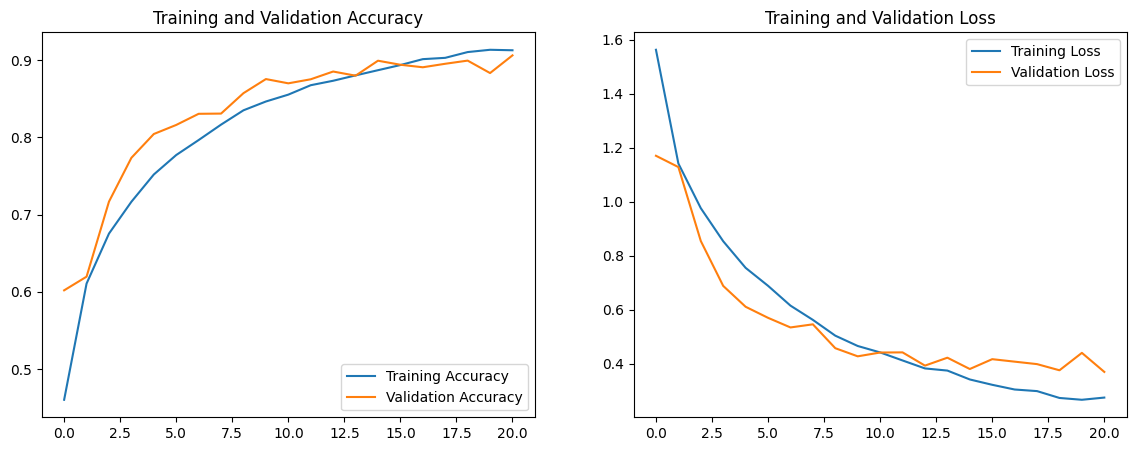

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Predict

# Predict

In [22]:
def predict_and_show_image(img_path, model, class_names):

    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0


    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    confidence = np.max(predictions)
    predicted_class_name = class_names[predicted_class_index]


    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_name} ({confidence:.2f} confidence)')
    plt.axis('off')
    plt.show()

    return predicted_class_name, confidence

1/1 [==============================] - 0s 82ms/step


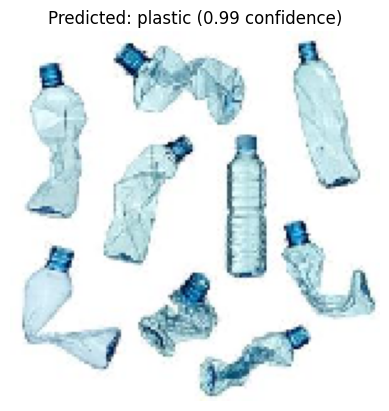

Predicted class: plastic 
confidence: 0.99


In [37]:
#bottle

img_path = '/content/sampah3.jpg'
class_names = list(train_generator.class_indices.keys())
predicted_class_name, confidence = predict_and_show_image(img_path, model, class_names)
print(f'Predicted class: {predicted_class_name} ')
print(f'confidence: {confidence:.2f}')

1/1 [==============================] - 0s 18ms/step


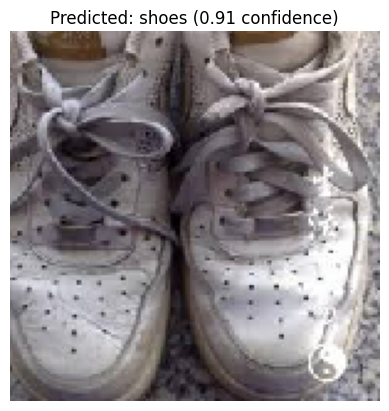

Predicted class: shoes 
confidence: 0.91


In [34]:
#shoes

img_path = '/content/sampah5.jpeg'
class_names = list(train_generator.class_indices.keys())
predicted_class_name, confidence = predict_and_show_image(img_path, model, class_names)
print(f'Predicted class: {predicted_class_name} ')
print(f'confidence: {confidence:.2f}')

1/1 [==============================] - 0s 25ms/step


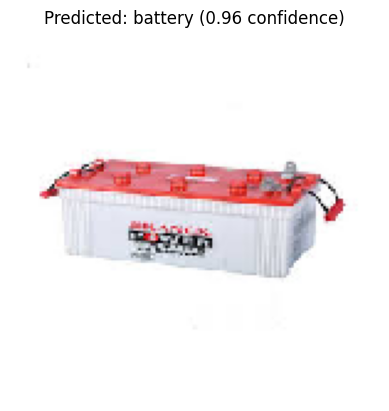

Predicted class: battery 
confidence: 0.96


In [38]:
#battery

img_path = '/content/sampah7.jpeg'
class_names = list(train_generator.class_indices.keys())
predicted_class_name, confidence = predict_and_show_image(img_path, model, class_names)
print(f'Predicted class: {predicted_class_name} ')
print(f'confidence: {confidence:.2f}')

1/1 [==============================] - 0s 89ms/step


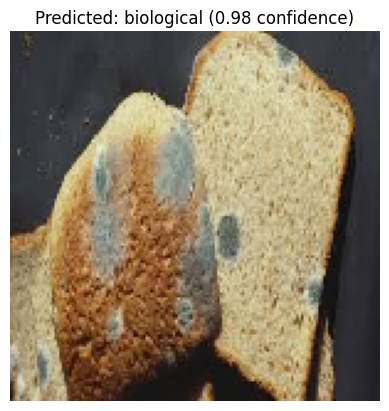

Predicted class: biological 
confidence: 0.98


In [39]:
#battery

img_path = '/content/sampah8.jpeg'
class_names = list(train_generator.class_indices.keys())
predicted_class_name, confidence = predict_and_show_image(img_path, model, class_names)
print(f'Predicted class: {predicted_class_name} ')
print(f'confidence: {confidence:.2f}')

1/1 [==============================] - 0s 26ms/step


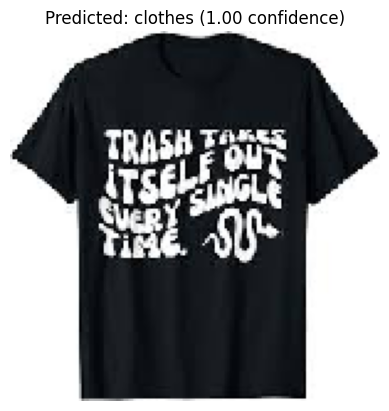

Predicted class: clothes 
confidence: 1.00


In [42]:
#clothes

img_path = '/content/sampah.jpeg'
class_names = list(train_generator.class_indices.keys())
predicted_class_name, confidence = predict_and_show_image(img_path, model, class_names)
print(f'Predicted class: {predicted_class_name} ')
print(f'confidence: {confidence:.2f}')

1/1 [==============================] - 0s 17ms/step


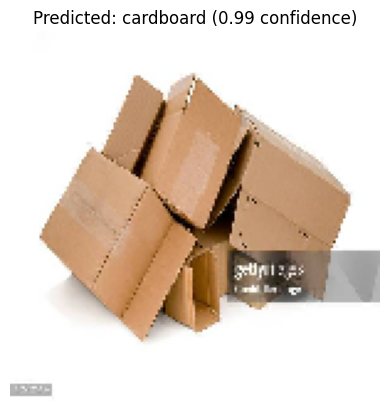

Predicted class: cardboard 
confidence: 0.99


In [51]:
#cardboard

img_path = '/content/s.jpeg'
class_names = list(train_generator.class_indices.keys())
predicted_class_name, confidence = predict_and_show_image(img_path, model, class_names)
print(f'Predicted class: {predicted_class_name} ')
print(f'confidence: {confidence:.2f}')

# Convert Model

TF Lite

In [52]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
from google.colab import files

files.download('/content/model.tflite')
